In [68]:
# Step 0: Imports & constants
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import set_config
import joblib

# Optional for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# nicer pipeline display in notebook (optional)
set_config(display='diagram')
plt.style.use('ggplot')

## Step 1 — Load data & quick inspection

In [69]:
# Step 1: Load dataset
df = pd.read_csv('manufacturing_dataset_1000_samples.csv')
df.columns = [c.strip() for c in df.columns]   # trim whitespace from column names

print("Shape:", df.shape)
display(df.head())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

Shape: (1000, 19)


,Timestamp,Injection_Temperature,Injection_Pressure,Cycle_Time,Cooling_Time,Material_Viscosity,Ambient_Temperature,Machine_Age,Operator_Experience,Maintenance_Hours,Shift,Machine_Type,Material_Grade,Day_of_Week,Temperature_Pressure_Ratio,Total_Cycle_Time,Efficiency_Score,Machine_Utilization,Parts_Per_Hour
0,2023-01-01 00:00:00,221.0,136.0,28.7,13.6,375.5,28.0,3.8,11.2,64,Evening,Type_B,Economy,Thursday,1.625,42.3,0.063,0.510,36.5
1,2023-01-01 01:00:00,213.3,128.9,34.5,14.0,215.8,22.6,6.8,6.3,58,Night,Type_A,Standard,Wednesday,1.655,48.5,0.037,0.389,29.9
2,2023-01-01 02:00:00,222.8,115.9,19.9,9.5,307.0,25.3,4.2,9.6,47,Day,Type_A,Standard,Monday,1.922,29.4,0.061,0.551,56.9
3,2023-01-01 03:00:00,233.3,105.3,39.2,13.1,137.8,26.0,9.2,8.6,49,Evening,Type_A,Premium,Saturday,2.215,52.3,0.054,0.293,31.0
4,2023-01-01 04:00:00,212.2,125.5,45.0,9.9,298.2,23.6,6.2,23.0,49,Night,Type_B,Premium,Monday,1.691,54.9,0.145,0.443,15.0



Data types:
 Timestamp                      object
Injection_Temperature         float64
Injection_Pressure            float64
Cycle_Time                    float64
Cooling_Time                  float64
Material_Viscosity            float64
Ambient_Temperature           float64
Machine_Age                   float64
Operator_Experience           float64
Maintenance_Hours               int64
Shift                          object
Machine_Type                   object
Material_Grade                 object
Day_of_Week                    object
Temperature_Pressure_Ratio    float64
Total_Cycle_Time              float64
Efficiency_Score              float64
Machine_Utilization           float64
Parts_Per_Hour                float64
dtype: object

Missing values per column:
 Timestamp                      0
Injection_Temperature          0
Injection_Pressure             0
Cycle_Time                     0
Cooling_Time                   0
Material_Viscosity            20
Ambient_Temperature    

## Step 2 — Quick EDA (statistics & categorical value counts)

In [70]:
# Step 2: Quick EDA
display(df.describe().T)

# Show counts for categorical columns that are expected
for col in ['Shift','Machine_Type','Material_Grade','Day_of_Week']:
    if col in df.columns:
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts(dropna=False))

,count,mean,std,min,25%,50%,75%,max
Injection_Temperature,1000.0,215.315900,11.995507,180.000,207.20000,215.3000,222.80000,300.000
Injection_Pressure,1000.0,116.075000,14.667246,80.000,105.90000,115.9500,125.92500,150.000
Cycle_Time,1000.0,35.851700,8.353490,16.300,28.80000,36.8500,45.00000,60.000
Cooling_Time,1000.0,11.923200,2.304290,8.000,10.27500,11.9000,13.50000,19.900
Material_Viscosity,980.0,251.630714,73.348695,104.600,200.90000,242.7000,295.30000,1000.000
Ambient_Temperature,980.0,22.941224,2.773712,18.000,20.80000,22.9000,25.10000,28.000
Machine_Age,1000.0,7.855900,3.900798,1.000,4.70000,7.9000,11.10000,15.000
Operator_Experience,980.0,30.795204,27.684769,1.000,9.80000,22.1000,43.42500,120.000
Maintenance_Hours,1000.0,50.580000,16.014558,26.000,45.00000,50.0000,55.00000,500.000
Temperature_Pressure_Ratio,1000.0,1.885852,0.274323,1.286,1.68375,1.8495,2.04425,2.843



Value counts for Shift:
Shift
Day        517
Evening    277
Night      206
Name: count, dtype: int64

Value counts for Machine_Type:
Machine_Type
Type_A    384
Type_B    347
Type_C    269
Name: count, dtype: int64

Value counts for Material_Grade:
Material_Grade
Standard    591
Premium     210
Economy     199
Name: count, dtype: int64

Value counts for Day_of_Week:
Day_of_Week
Friday       168
Wednesday    155
Thursday     150
Saturday     141
Tuesday      138
Monday       136
Sunday       112
Name: count, dtype: int64


## Step 3 — Visual EDA (histograms, boxplots, correlation)

In [71]:
# Step 3: Visual EDA (run in notebook to see plots)
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != 'Parts_Per_Hour']

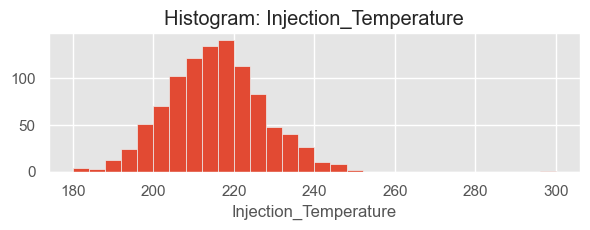

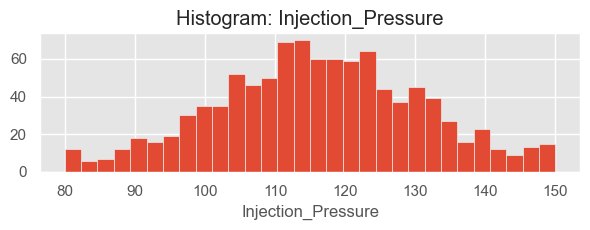

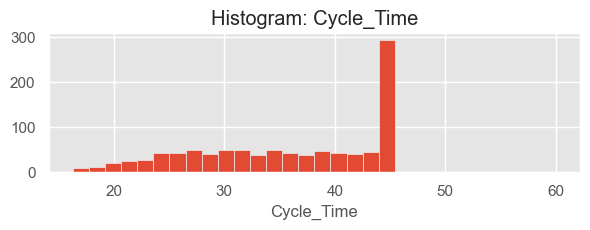

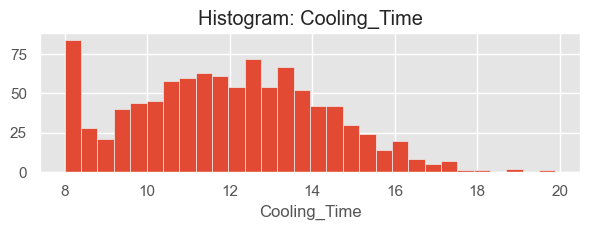

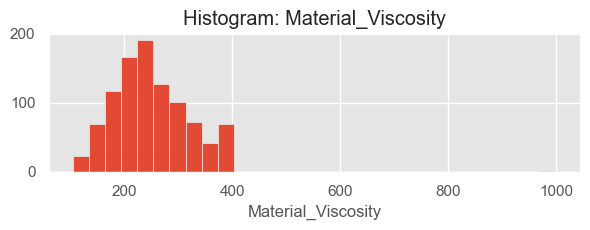

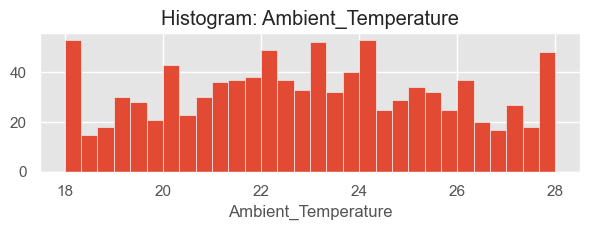

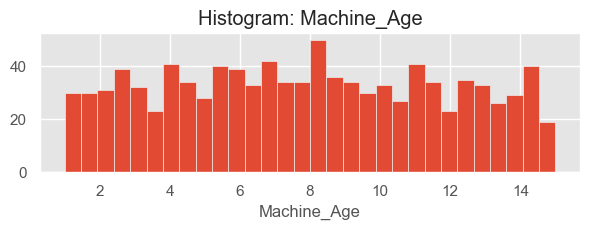

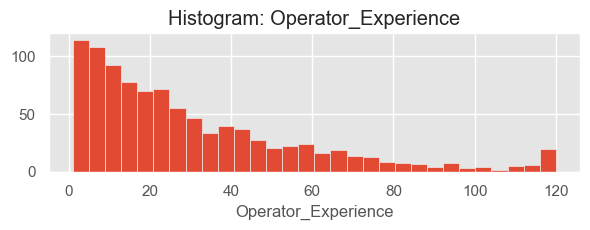

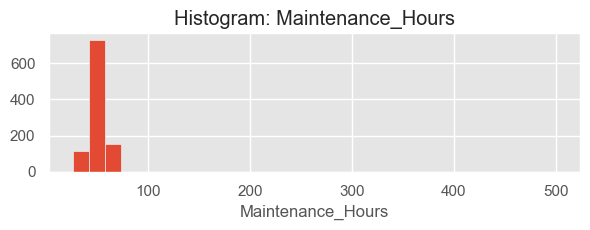

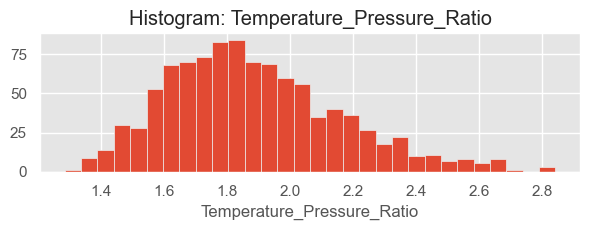

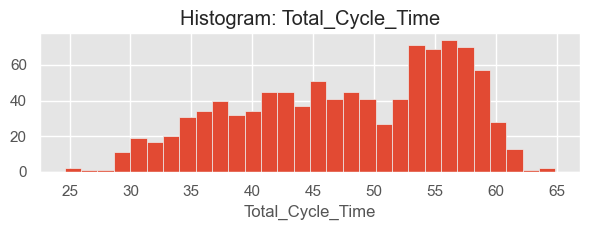

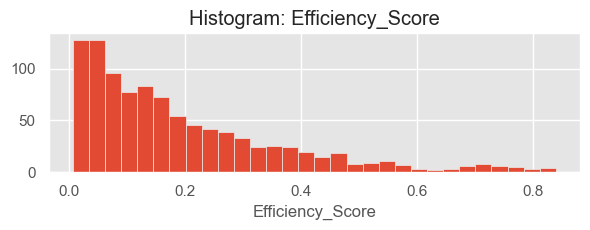

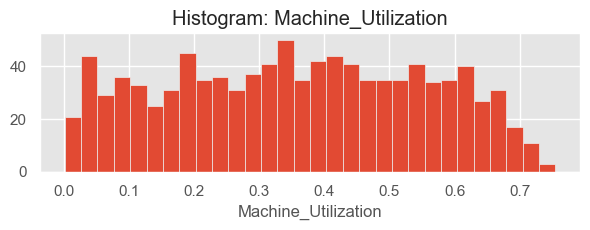

In [72]:
# histograms
for col in numeric_cols:
    plt.figure(figsize=(6,2.4))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histogram: {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

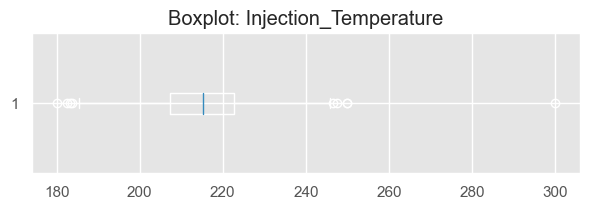

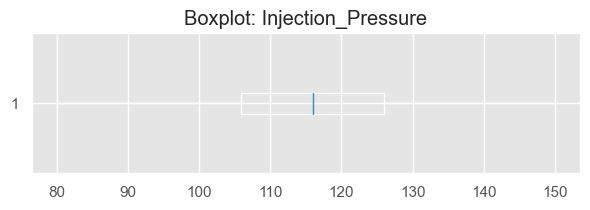

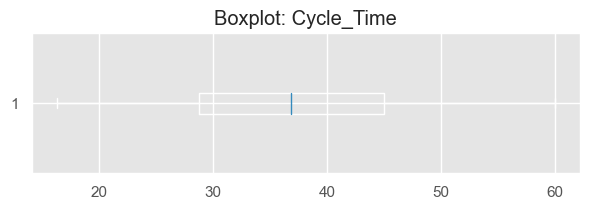

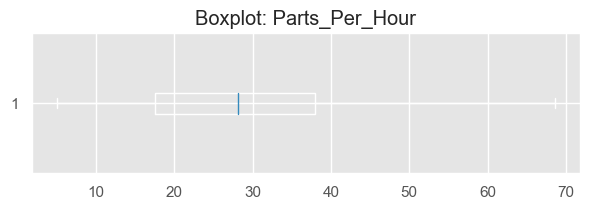

In [73]:
# boxplots for a few key columns

for col in ['Injection_Temperature','Injection_Pressure','Cycle_Time','Parts_Per_Hour']:
    if col in df.columns:
        plt.figure(figsize=(6,2.2))
        plt.boxplot(df[col].dropna(), vert=False)
        plt.title(f'Boxplot: {col}')
        plt.tight_layout()
        plt.show()

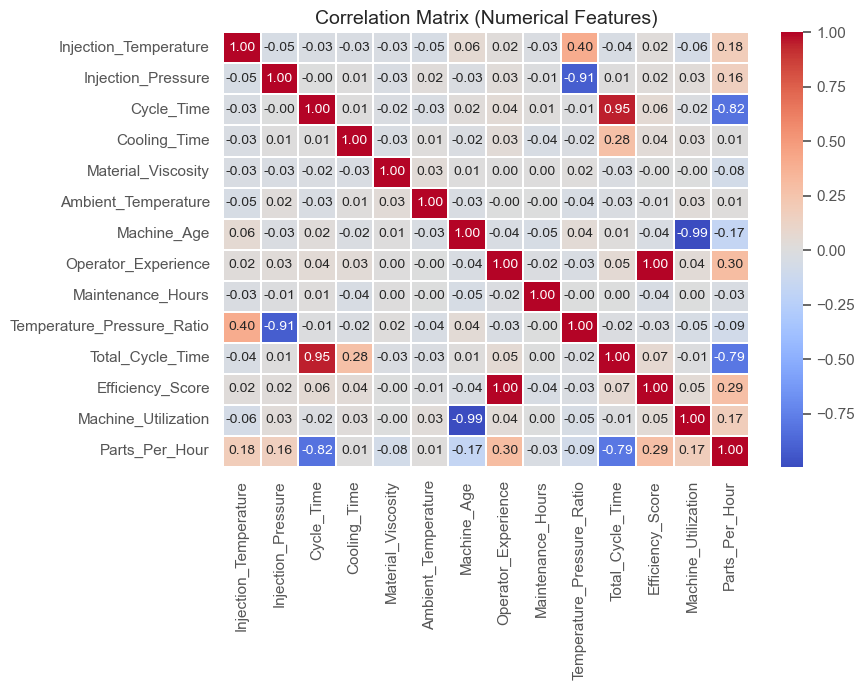

In [74]:
num_for_corr = numeric_cols + (['Parts_Per_Hour'] if 'Parts_Per_Hour' in df.columns else [])

# Compute correlation matrix
corr = df[num_for_corr].corr()

# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Correlation Matrix (Numerical Features)', fontsize=14)
plt.tight_layout()
plt.show()

## Step 4 — Feature engineering & missing-value plan

In [75]:
# Create engineered features if not present
if 'Temperature_Pressure_Ratio' not in df.columns and ('Injection_Temperature' in df.columns and 'Injection_Pressure' in df.columns):
    df['Temperature_Pressure_Ratio'] = df['Injection_Temperature'] / df['Injection_Pressure']
    print("Created Temperature_Pressure_Ratio")

if 'Total_Cycle_Time' not in df.columns and ('Cycle_Time' in df.columns and 'Cooling_Time' in df.columns):
    df['Total_Cycle_Time'] = df['Cycle_Time'] + df['Cooling_Time']
    print("Created Total_Cycle_Time")

In [76]:
# List features we'll use (from project spec)
categorical_features = [c for c in ['Shift','Machine_Type','Material_Grade','Day_of_Week'] if c in df.columns]
numerical_features = [c for c in ['Injection_Temperature','Injection_Pressure','Cycle_Time','Cooling_Time',
                                  'Material_Viscosity','Ambient_Temperature','Machine_Age',
                                  'Operator_Experience','Maintenance_Hours','Temperature_Pressure_Ratio',
                                  'Total_Cycle_Time','Efficiency_Score','Machine_Utilization']
                      if c in df.columns]

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

# Confirm target
assert 'Parts_Per_Hour' in df.columns, "Target 'Parts_Per_Hour' not found"

Categorical features: ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
Numerical features: ['Injection_Temperature', 'Injection_Pressure', 'Cycle_Time', 'Cooling_Time', 'Material_Viscosity', 'Ambient_Temperature', 'Machine_Age', 'Operator_Experience', 'Maintenance_Hours', 'Temperature_Pressure_Ratio', 'Total_Cycle_Time', 'Efficiency_Score', 'Machine_Utilization']


## Step 5 — Prepare preprocessing pipelines (imputer + scaler + encoder)

In [77]:
# Step 5: Preprocessing pipelines (impute -> scale -> encode)
num_imputer = SimpleImputer(strategy='median')
num_scaler = StandardScaler()
num_pipeline = Pipeline(steps=[
    ('imputer', num_imputer),
    ('scaler', num_scaler)
])

cat_imputer = SimpleImputer(strategy='most_frequent')
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_pipeline = Pipeline(steps=[
    ('imputer', cat_imputer),
    ('onehot', cat_encoder)
])


preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

# Quick check: show the preprocessor pipeline
print(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Injection_Temperature', 'Injection_Pressure',
                                  'Cycle_Time', 'Cooling_Time',
                                  'Material_Viscosity', 'Ambient_Temperature',
                                  'Machine_Age', 'Operator_Experience',
                                  'Maintenance_Hours',
                                  'Temperature_Pressure_Ratio',
                                  'Total_Cycle_Time', 'Efficiency_Score',
                                  'Machine_Utilization']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequ

## Step 6 — Train/test split

In [78]:
# Step 6: Split into train/test
X = df[categorical_features + numerical_features]
y = df['Parts_Per_Hour'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (800, 17) Test shape: (200, 17)


## Step 7 — Baseline: Linear Regression (pipeline)

In [79]:
# Step 7: Baseline linear regression
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression → MSE: {mse:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.4f}")

Linear Regression → MSE: 12.305, RMSE: 3.508, MAE: 2.717, R2: 0.9057


## Step 8 — Residual plots & Actual vs Predicted

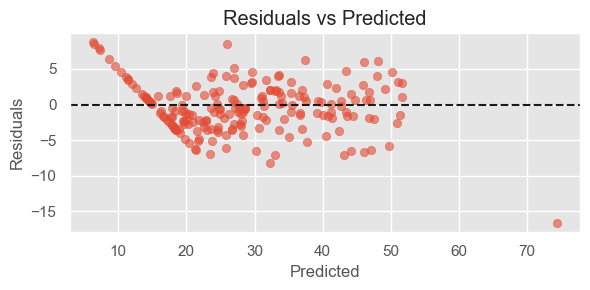

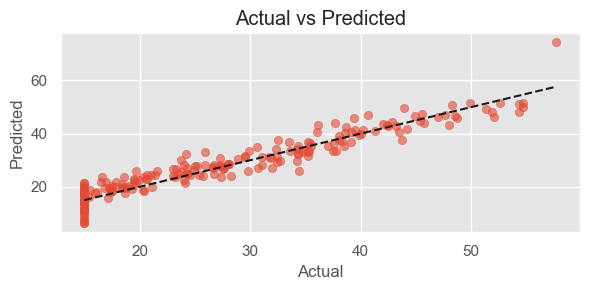

In [80]:
# Step 8: Diagnostics plots
residuals = y_test - y_pred

plt.figure(figsize=(6,3))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='k')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()

## Step 9 — VIF (multicollinearity) — optional but useful

In [81]:
# Step 9: VIF for numerical features (compute on training data after median-imputation)
# Build a numeric matrix with imputed values (no scaling required for VIF)
X_num_train = X_train[numerical_features].copy()
X_num_train = X_num_train.fillna(X_num_train.median())

# If any constant columns exist, drop them (VIF would be infinite)
X_num_train = X_num_train.loc[:, X_num_train.nunique() > 1]

vif_data = pd.DataFrame()
vif_data['feature'] = X_num_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_num_train.values, i) for i in range(X_num_train.shape[1])]

print("VIF per numeric feature:\n", vif_data.sort_values('VIF', ascending=False))


VIF per numeric feature:
                        feature          VIF
0        Injection_Temperature  1642.298784
10            Total_Cycle_Time  1394.654522
1           Injection_Pressure  1136.678790
9   Temperature_Pressure_Ratio  1067.755695
2                   Cycle_Time   793.835073
6                  Machine_Age   389.370631
12         Machine_Utilization   334.914000
7          Operator_Experience   207.733653
11            Efficiency_Score   206.889373
3                 Cooling_Time   122.413623
5          Ambient_Temperature    70.048184
4           Material_Viscosity    13.218332
8            Maintenance_Hours    10.474357


## Step 10 — Regularized models + GridSearch (Ridge and Lasso)

In [82]:
# Step 10: Compare Ridge and Lasso with simple grid search on alpha
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge())])
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(max_iter=5000))])

ridge_params = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
lasso_params = {'regressor__alpha': [0.001, 0.01, 0.1, 1]}

ridge_cv = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='r2', n_jobs=-1)
lasso_cv = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='r2', n_jobs=-1)

print("Fitting Ridge CV...")
ridge_cv.fit(X_train, y_train)
print("Best Ridge alpha:", ridge_cv.best_params_, " Best CV R2:", ridge_cv.best_score_)

print("Fitting Lasso CV...")
lasso_cv.fit(X_train, y_train)
print("Best Lasso alpha:", lasso_cv.best_params_, " Best CV R2:", lasso_cv.best_score_)

# Evaluate best on test set
best_ridge = ridge_cv.best_estimator_
best_lasso = lasso_cv.best_estimator_

y_ridge = best_ridge.predict(X_test)
y_lasso = best_lasso.predict(X_test)

print("Ridge on test R2:", r2_score(y_test, y_ridge))
print("Lasso on test R2:", r2_score(y_test, y_lasso))


Fitting Ridge CV...
Best Ridge alpha: {'regressor__alpha': 0.01}  Best CV R2: 0.9168175592621453
Fitting Lasso CV...
Best Lasso alpha: {'regressor__alpha': 0.01}  Best CV R2: 0.9023690010220593
Ridge on test R2: 0.9057069795378345
Lasso on test R2: 0.9061583523255183


## Step 11 — Choose best model and save

In [83]:
# Step 11: pick the best performing model on test R2 and save
models_eval = {
    'linear': r2,
    'ridge': r2_score(y_test, y_ridge),
    'lasso': r2_score(y_test, y_lasso)
}
print("Test R2 scores:", models_eval)

best_name = max(models_eval, key=models_eval.get)
if best_name == 'linear':
    best_model = baseline_pipeline
elif best_name == 'ridge':
    best_model = best_ridge
else:
    best_model = best_lasso

save_path = 'equipment_output_model_best.joblib'
joblib.dump(best_model, save_path)
print(f"Saved best model ({best_name}) to {save_path}")

# also save predictions comparison
pred_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': (y_pred if best_name=='linear' else (y_ridge if best_name=='ridge' else y_lasso))})
pred_df.to_csv('predictions_comparison.csv', index=False)
print("Saved predictions to predictions_comparison.csv")

Test R2 scores: {'linear': 0.9057073405009886, 'ridge': 0.9057069795378345, 'lasso': 0.9061583523255183}
Saved best model (lasso) to equipment_output_model_best.joblib
Saved predictions to predictions_comparison.csv


In [87]:
import sklearn
print(sklearn.__version__)


1.6.1


In [88]:
!pip install scikit-learn>=1.7.2